# Contextual Bandits for Booking.com

Contextual Bandits for Booking.com optimizing the margin of booking.com
## Feautures of Environment
* Limited room availability depending on hotel
* User preferences, which decide whether a user will book a hotel or not
* Partner Program which promotes certain hotels
* Different margins for different hotels

## Implemented Agents
* Random
* Adaptive Greedy
* Epsilon Greedy
* Thompson Sampling
* UCB
* Embedding Agent
  - Offline: Only trained once with historical data
  - Online / Offline: Trained with historical data and from time to time retrained with new data
  - Online: Switch between random exploration and exploitation with decreasing probability on exploration
* Hybrid Agent: Embeddings + Meta Information about user & hotels

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from copy import copy, deepcopy
import random
from scipy.stats import norm
from scipy.stats import logistic

In [2]:
def random_argmax(rng, list_):
    """ similar to np.argmax but return a random element among max
        when multiple max exists."""
    return rng.choice(np.argwhere(list_ == list_.max()).flatten())

In [3]:
np.set_printoptions(precision=2)

In [4]:
# Disable Warnings
import warnings
warnings.filterwarnings("ignore")

## Environment

In [5]:
class ExplicitFeedback:
    """ A rating environment with explicit feedback.
        User and hotels are represented by points in R^k
        User interest in a hotel is modeled by a parametric function
        R_{u,h} = f(u,h) = f(W_u, W_h)
        Example of function include dot product (cosine similarity), but then take margin into account
        f(W_u, W_h) = sigmoid ( \sum_k w_{u,k} . w_{h,k} ) 
        R_{u,h} = m_{h} * (f(W_u, W_h) > threshold)
        action: Recommend one hotel, which maximizes the margin
    """

    def __init__(self, nb_users=30, nb_hotels=10, 
                 internal_embedding_size=20,
                 displayed_users_embedding_size=10,
                 displayed_hotels_embedding_size=10,
                 noise_size=3,
                 threshold=.2,
                 max_avail=150,
                 min_avail=10,
                 seed=None):
        self.nb_users = nb_users
        self.nb_hotels = nb_hotels
        self.internal_embedding_size = internal_embedding_size
        self.displayed_users_embedding_size = displayed_users_embedding_size
        self.displayed_hotels_embedding_size = displayed_hotels_embedding_size
        self.noise_size = noise_size
        self._rng = np.random.RandomState(seed)
        self.threshold = threshold
        self.max_avail = max_avail
        self.min_avail = min_avail
        self.variable_size = self.displayed_users_embedding_size + self.displayed_hotels_embedding_size + self.noise_size
        
        self.action_size = self.nb_hotels
        self.sampling_limit = self.nb_users * self.nb_hotels * 50
        self.current_number_of_samples = 0
        self.user_mean = np.ones(self.internal_embedding_size)
        self.user_var = np.ones(self.internal_embedding_size)
        self.hotels_mean = np.ones(self.internal_embedding_size)
        self.hotels_var = np.ones(self.internal_embedding_size)
        self.users_embedding = None
        self.hotels_embedding = None
        self.z_cut_points = None
        self.done = False
        self.hotel_rooms = np.random.randint(low=self.min_avail, high=self.max_avail, size=self.nb_hotels)
        self.hotel_sponsored = np.random.randint(low=0,high=1, size=nb_hotels)

    def step(self, action):
        # check if behind done
        if self.done:
            print("You are calling step after it return done=True.\n"
                  "You should reset the environment.")

        assert action < self.action_size
        self.action = action
        
        # map action to hotels
        self.recommended_hotel = self.state[action][1]

        # verify room availability and update rooms available
        assert self.hotel_rooms[self.recommended_hotel] > 0
        self.hotel_rooms[self.recommended_hotel] = self.hotel_rooms[self.recommended_hotel] - 1

        # see if there are still rooms available
        available = np.argwhere(self.hotel_rooms > 0)
        if not available.any():
          print('All rooms are already booked')
          print('Moving to the day after')
          self.hotel_rooms = np.random.randint(low=self.min_avail, high=self.max_avail, size=self.nb_hotels)
        
        # compute potential rewards
        potential_rewards = [self._get_user_hotels_rating(self.current_user, i) 
                      for i in np.argwhere(self.hotel_rooms > 0).flatten()]
        optimal_return = np.max(potential_rewards)

        # compute reward R_t
        self.current_rating = self._get_user_hotels_rating(self.current_user, self.recommended_hotel)
        self.reward = self.current_rating
        
        # check if done
        self.current_number_of_samples += 1
        if self.current_number_of_samples == self.sampling_limit:
            self.done = True

        # compute next state S_{t+1}
        self._next_state()

        # update action space t+1
        self.action_size = len(self.available_hotels)

        return self.reward, self.state, self.done, optimal_return

    def reset(self, seed=None):
        self._rng = np.random.RandomState(seed)
        self.action_size = self.nb_hotels
        self.hotel_rooms = np.random.randint(low=self.max_avail/10, high=self.max_avail, size=self.nb_hotels)

        
        # create users and hotels embedding matrix
        self.users_embedding = self._rng.normal(loc=self.user_mean,
                                                scale=self.user_var,
                                                size=(self.nb_users, self.internal_embedding_size))
        self.hotels_embedding = self._rng.normal(loc=self.hotels_mean,
                                                scale=self.hotels_var,
                                                size=(self.nb_hotels, self.internal_embedding_size))
        self.margin = self._rng.rand(self.nb_hotels)


        # Let X = users_embedding and Y = hotels_embedding
        # In order to properly map float into integers, we need to know the distribution of
        # Z = \sum_k X_k.Y_k
        # E[Z] = \sum_k E[X_k.Y_k] = \sum_k E[X_k]E[Y_k]
        # Var[Z] = \sum_k Var[X_k.Y_k] = \sum_k Var[X_k]Var[Y_k] + Var[X_k]E[Y_k]^2 + Var[Y_k]E[X_k]^2
        z_mean = self.user_mean.dot(self.hotels_mean)
        z_var = self.user_var.dot(self.hotels_var) + self.user_var.dot(np.square(self.hotels_mean)) + \
                self.hotels_var.dot(np.square(self.user_mean))
        z = norm(z_mean, np.sqrt(z_var))
        # to get 5 values, we need 4 cut points
        self.z_cut_points = z.ppf([self.threshold]) # 0.2, 0.4, 0.6, 0.8 # you can control the distribution of ratings here.
        self.done = False
        self.current_number_of_samples = 0

        self._next_state()
        return self.state

    def _get_user_hotels_rating(self, user, hotel):
        sponsor_addition = 1
        gamma = 0.7

        # Check if the user likes the hotel and will book it
        will_book = (self.users_embedding[user].dot(self.hotels_embedding[hotel])) 
        will_book = np.searchsorted(self.z_cut_points, will_book)

        # Calculate the value of the booking including the bonus
        if( self.hotel_sponsored[hotel] == 1):
          score = self.margin[hotel] * (1-gamma) + sponsor_addition * (gamma)
        else:
          score = self.margin[hotel] # * (1-gamma) + 0 * (gamma)     

        return int((will_book * score * 100) / 10)

    def _get_variables(self, user, hotel):
        user_embedding = self.users_embedding[user]
        hotel_embedding = self.hotels_embedding[hotel]
        if self.displayed_users_embedding_size + self.displayed_hotels_embedding_size > 0:
            variables = np.array([user_embedding[:self.displayed_users_embedding_size],
                                  hotel_embedding[:self.displayed_hotels_embedding_size]])

            if self.noise_size > 0:
                noise = self._rng.normal(loc=np.ones(self.noise_size),
                                         scale=np.ones(self.noise_size),
                                         size=self.noise_size)
                variables = np.append(variables, noise)

            return variables

    def _get_new_user(self):
        # Our availability does not depend on the user, but rather on the hotel, hence we can just pick any user 
        return self._rng.randint(0, self.nb_users)

    def _next_state(self):
        # Pick a user
        if self.current_number_of_samples < self.sampling_limit:
            self.current_user = self._get_new_user()
        else:
            self.current_user = None

        # List available hotels
        self.available_hotels = np.argwhere(self.hotel_rooms > 0)

        self.state = list()
        for i in self.available_hotels:
            hotel = i[0]
            # Compute variables
            variables = self._get_variables(self.current_user, hotel)
            self.state.append([self.current_user, hotel, variables])

Some simple tests to see if the system is working. We first create the environment, than choose an action and observe the reward.

In [6]:
env = ExplicitFeedback()
env.reset(seed=2020)
reward, next_state, done, optimal_return = env.step(6)
print('reward: ', reward)

reward:  6


We recommend the sixth hotel of the list (hotel 6) to the user and the margin as reward. If the margin is 0 he did not book it!
We also get the next state, that is the next user connect to our application, the list of available hotels for recommendations and a list of features.

In [7]:
next_state

[[9,
  0,
  array([-0.83,  0.64, -0.09,  1.04,  1.32, -0.33,  0.81,  0.56,  1.53,
          1.3 ,  1.87,  1.63,  1.92,  1.33,  1.88, -0.08,  1.43,  1.44,
          0.96, -0.91,  0.94,  1.75,  0.87])],
 [9,
  1,
  array([-0.83,  0.64, -0.09,  1.04,  1.32, -0.33,  0.81,  0.56,  1.53,
          1.3 ,  0.4 ,  1.47,  1.78,  1.04,  2.87,  0.52,  1.7 ,  1.19,
          1.19,  1.33, -1.75,  2.35,  1.19])],
 [9,
  2,
  array([-0.83,  0.64, -0.09,  1.04,  1.32, -0.33,  0.81,  0.56,  1.53,
          1.3 ,  1.18, -0.06,  0.64,  0.64, -0.05,  0.03,  2.61,  1.25,
          0.33,  0.47,  1.  ,  3.37,  1.98])],
 [9,
  3,
  array([-0.83,  0.64, -0.09,  1.04,  1.32, -0.33,  0.81,  0.56,  1.53,
          1.3 ,  1.01,  0.3 ,  0.29,  1.03,  0.97,  2.12,  0.5 ,  0.55,
          1.39,  0.4 ,  1.47,  2.34,  0.49])],
 [9,
  4,
  array([-0.83,  0.64, -0.09,  1.04,  1.32, -0.33,  0.81,  0.56,  1.53,
          1.3 , -0.14,  1.17,  1.64,  2.71,  2.61,  1.2 ,  0.88,  1.69,
          2.23,  2.02, -0.  ,  0.93,  0.07

## User-Hotel recommender system

### Run experiment
In order to make Agent and Environment interract, we can create an experiment, parametrized by the number of step we will be running.

In [7]:
def run_exp(agent, env, nb_steps, env_seed):
    rewards = np.zeros(nb_steps)
    regrets = np.zeros(nb_steps)
    actions = np.zeros(nb_steps)
    items = np.zeros(nb_steps)
    users   = np.zeros(nb_steps) 
    variables = []
    context = env.reset(env_seed)
    rating_matrix = np.zeros((env.nb_users, env.nb_hotels))
    for i in range(nb_steps):
        # Select action from agent policy.
        action = agent.act(context)
        
        # Play action in the environment and get reward.
        reward, next_context, done, optimal_return = env.step(action)
        
        # Update history
        user = context[0][0]
        item = context[action][1]
        rating = reward
        rating_matrix[user, item] = rating
        
        # Update agent.
        agent.update(context, action, reward)
        
        # Save history.
        variables.append(context[action][2])
        rewards[i] = reward
        actions[i] = action
        users[i]   = user
        regrets[i] = optimal_return - reward
        items[i] = item
        
        context = next_context


    reward = rewards.sum()
    regret = np.sum(regrets)
    return {'reward': reward, 
            'regret': regret,
            'rewards': rewards,
            'users' : users,            
            'regrets': regrets,
            'actions': actions,
            'cum_rewards': np.cumsum(rewards), 
            'cum_regrets': np.cumsum(regrets),
            'rating_matrix': rating_matrix,
            'items': items,
            'variables': variables
            }


## Agents
### Setup Environment for comparison

In [8]:
env = ExplicitFeedback()
nb_exp = 100
nb_exp_emb = 20 #Lower Number of experiments for embedding agents since they take a lot longer
nb_steps = 500
results = {}

### Random

In [9]:
class Random:
    """ Random agent. """
    def __init__(self, nb_arms, seed=None):
        self._nb_arms = nb_arms
        self._rng = np.random.RandomState(seed)
        
    def act(self, context):
        action = self._rng.randint(len(context)) # note that action size is changing
        return action
        
    def update(self, context, action, reward):
        pass


In [11]:
#nb_exp = 100
#nb_steps = 100
regret = np.zeros(nb_exp)
regrets = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    env = ExplicitFeedback()
    agent = Random(None, seed=i)
    exp = run_exp(agent, env, nb_steps, env_seed=i)
    regret[i] = exp['regret'] 
    regrets[i] = exp['cum_regrets']

results["Random"] = regrets.mean(axis=0)

All rooms are already booked
Moving to the day after


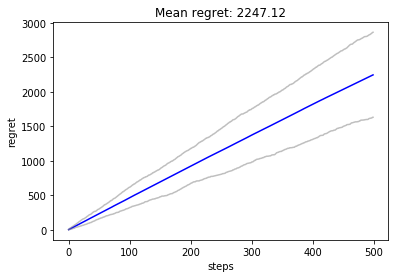

In [12]:
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

### AdaptiveGreedy

In [13]:
class AdaptiveGreedy():
  def __init__(self, nb_arms, c=0.2):
    self.nb_arms = nb_arms
    self.c = c
    self.t = 0
    self.cum_rewards = np.zeros(nb_arms)
    self.nb_tries = np.zeros(nb_arms)

  def act(self, context):
    context_id = np.full(self.nb_arms, -1, dtype=int)
    for i,_context in enumerate(context):
      # _context[1] contains the hotel id
      # _context[2] contains the variables
      context_id[_context[1]] = i
    available = np.asarray(context)[:,2]

    k = np.shape(available)[0]
    t = np.sum(self.nb_tries)
    if np.sum(self.nb_tries) == 0 or np.random.random() < self.c / (self.c + t):
        return np.random.randint(k)
    else:
      action = -1
      index1 = np.where(self.nb_tries > 0 )
      index2 = np.where(context_id > -1)
      index = np.intersect1d(index1, index2)
      if( index.shape[0] == 0):
        action = np.random.randint(k)
      else:
        index = index[np.argmax(self.cum_rewards[index] / self.nb_tries[index])]
        action = context_id[index]
      return action


  def update(self, context, action, reward):
    item = context[action][1]
    self.nb_tries[item] = self.nb_tries[item]+1
    self.cum_rewards[item] = self.cum_rewards[item] + reward

In [14]:
adaptive_agent = AdaptiveGreedy(env.nb_hotels)
run_exp(adaptive_agent, env, nb_steps=100, env_seed=2020)

{'reward': 414.0,
 'regret': 423.0,
 'rewards': array([3., 9., 9., 0., 9., 0., 9., 0., 9., 9., 9., 9., 0., 0., 9., 9., 9.,
        6., 9., 9., 9., 9., 0., 9., 9., 9., 0., 9., 9., 9., 9., 9., 9., 9.,
        9., 9., 9., 9., 0., 3., 3., 3., 3., 3., 0., 6., 6., 6., 0., 6., 6.,
        0., 0., 6., 6., 0., 0., 6., 6., 6., 0., 6., 0., 0., 6., 0., 0., 6.,
        0., 3., 0., 0., 3., 3., 0., 0., 0., 3., 3., 3., 0., 3., 3., 3., 3.,
        3., 0., 0., 0., 0., 3., 0., 0., 3., 3., 0., 0., 3., 3., 3.]),
 'users': array([26.,  9., 21., 11.,  2., 11., 21., 29., 19., 23.,  3.,  6., 29.,
        11., 15.,  8., 15., 18.,  9., 25., 25., 15., 11., 10., 10.,  3.,
         5., 28., 12., 23., 24., 16., 12., 17.,  9., 22., 16., 27., 13.,
         1., 22.,  9., 21.,  6., 25., 14., 21.,  4.,  8., 14., 17., 11.,
        19., 15., 17., 25., 16., 28., 20.,  2.,  3., 23.,  7., 16.,  6.,
        12., 26., 21., 25., 21.,  7., 29., 20., 17., 29.,  7., 25.,  5.,
         6.,  2.,  0., 26.,  4., 20., 16., 14., 11.,  0.

In [15]:
#nb_exp = 100
#nb_steps = 100
regret = np.zeros(nb_exp)
regrets = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    agent = AdaptiveGreedy(env.nb_hotels, c=10)
    exp = run_exp(agent, env, nb_steps, env_seed=i)
    regret[i] = exp['regret'] 
    regrets[i] = exp['cum_regrets']

results["AdaptiveGreedy"] = regrets.mean(axis=0)

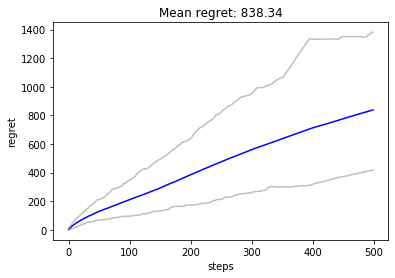

In [16]:
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

### Epsilon Greedy

In [17]:
class EpsilonGreedy:
    """ Epsilon greedy agent. """
    def __init__(self, nb_arms, context_size, lr=.1, epsilon=.2, seed=None):
        self._nb_arms = nb_arms
        self._p = context_size
        self._lr = lr
        self._epsilon = epsilon
        self._rng = np.random.RandomState(seed)
        self._beta = np.zeros((nb_arms, self._p)) 
        self._n = np.zeros(nb_arms)
        self._pred_reward = np.zeros(nb_arms)
        
    def act(self, context):
        ###############
        context_f = np.zeros(shape=(self._nb_arms,self._p))
        context_id = np.full(self._nb_arms, -1, dtype=int)
        for i,_context in enumerate(context):
            # _context[1] contains the hotel id
            # _context[2] contains the variables
            context_f[_context[1]] = _context[2]
            context_id[_context[1]] = i
        ###############

        if self._rng.rand() < self._epsilon:
            action = self._rng.randint(len(context))
        else:
            pred_reward = np.einsum('ij,ij->i', context_f, self._beta)
            pred_reward[np.argwhere(context_id == -1)] = -100

            action = random_argmax(self._rng, pred_reward)
            action = context_id[action]

        return action
        
    def update(self, context, action, reward):
        """ Simple gradient descent. """
        ################
        _context = context[action][2]
        item = context[action][1]
        ################

        self._n[item] += 1
        grad = - _context * (reward - _context.dot(self._beta[item]))
        self._beta[item] = self._beta[item] - self._lr/self._n[item] * grad


In [18]:
eps_agent = EpsilonGreedy(env.nb_hotels, env.variable_size)
run_exp(eps_agent, env, nb_steps=100, env_seed=2020)

{'reward': 510.0,
 'regret': 345.0,
 'rewards': array([6., 2., 9., 0., 9., 0., 9., 6., 6., 5., 5., 5., 0., 0., 9., 9., 6.,
        0., 0., 5., 5., 2., 0., 0., 6., 5., 6., 5., 6., 5., 5., 5., 6., 5.,
        5., 6., 5., 5., 5., 5., 5., 5., 0., 9., 9., 0., 5., 9., 5., 6., 5.,
        9., 5., 5., 5., 5., 9., 5., 0., 3., 3., 5., 3., 5., 0., 6., 6., 0.,
        5., 5., 9., 9., 0., 9., 5., 6., 9., 3., 5., 5., 5., 5., 5., 0., 9.,
        9., 9., 9., 9., 9., 9., 6., 5., 5., 5., 5., 6., 5., 5., 5.]),
 'users': array([26.,  9., 21., 11.,  2., 11., 21., 29., 19., 23.,  3.,  6., 29.,
        11., 15.,  8., 15., 18.,  9., 25., 25., 15., 11., 10., 10.,  3.,
         5., 28., 12., 23., 24., 16., 12., 17.,  9., 22., 16., 27., 13.,
         6., 20., 13., 29.,  8., 24., 13., 27., 22., 16., 26., 18.,  3.,
        20., 20.,  4.,  5.,  9., 20., 25., 22., 20.,  1., 22.,  2., 25.,
        22., 26.,  8., 19., 28.,  8., 23., 11.,  1.,  2., 29.,  8., 23.,
         7., 27., 23.,  1., 14., 28.,  1., 21., 25., 15.

In [19]:
#nb_exp = 100
#nb_steps = 100
regret = np.zeros(nb_exp)
regrets = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    env.reset(seed=2020)
    eps_agent = EpsilonGreedy(env.nb_hotels, env.variable_size)
    res = run_exp(eps_agent, env, nb_steps, env_seed=i)
    regret[i] = res['regret'] 
    regrets[i] = res['cum_regrets']

results["Epsilon Greedy"] = regrets.mean(axis=0)

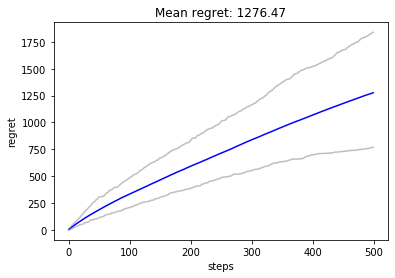

In [20]:
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05, axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95, axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

### Thompson agent

In [21]:
class BetaBernoulli(object):
    """ Beta Bernoulli Bayesian distribution. """
    def __init__(self, a=1, b=1, prior=np.ones(10)):
        self.a = a
        self.b = b
        self.n = copy(prior)  # number of {0,1} rewards

    def update(self, reward):
        self.n[int(reward)] += 1

    def sample(self, np_random):
        return np_random.beta(self.a + self.n[1], self.b + self.n[0])

from scipy.stats import t as student
class NormalGamma(object):
    """ NG(m, λ|µ = ·, κ = 0, α = −1/2, β = 0) """
    def __init__(self):
        self.mean = 0
        self.ss = 0
        self.n = 0

    def update(self, reward):
        self.n += 1
        # update mean and sum of square
        old_mean = self.mean
        self.mean +=  (reward - self.mean)/self.n
        self.ss += (reward - old_mean) * (reward - self.mean) # Welford's algorithm

    def sample(self, np_random):
        if self.n <= 2:
            return np.Inf
        else:
            return student.rvs(df=self.n-1, loc=self.mean, 
                               scale=self.ss/(self.n*self.n-1),
                               random_state=np_random)

class Thompson_agent():
    def __init__(self, nb_arms, a=1, b=1, seed=None):
        self._nb_arms = nb_arms
        self._rng = np.random.RandomState(seed)
        #self.dist = BetaBernoulli(a,b, prior =np.ones(nb_arms))
        dist=NormalGamma
        self._posterior = [dist() for i in range(self._nb_arms)]
        
    def act(self, context):
        available_hotels = np.asarray(context)[:,1]
        sample = np.array([self._posterior[i].sample(self._rng)
                           for i in available_hotels])
        action = np.argmax(sample)
        return action
        
    def update(self, context, action, reward):
        item = context[action][1]
        self._posterior[item].update(reward)
        return

In [22]:
thompson = Thompson_agent(env.nb_hotels)
run_exp(thompson, env, nb_steps=100, env_seed=2020)

{'reward': 650.0,
 'regret': 196.0,
 'rewards': array([5., 5., 5., 0., 9., 0., 0., 0., 4., 3., 0., 3., 2., 0., 2., 0., 6.,
        6., 6., 0., 0., 0., 0., 0., 2., 2., 2., 9., 9., 9., 9., 9., 9., 9.,
        9., 9., 9., 9., 9., 6., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
        9., 9., 9., 9., 0., 9., 9., 0., 9., 6., 9., 9., 9., 9., 9., 9., 9.,
        9., 9., 9., 6., 0., 9., 9., 0., 9., 9., 9., 9., 9., 9., 3., 9., 9.,
        9., 9., 9., 0., 9., 9., 9., 9., 0., 9., 9., 9., 9., 9., 9.]),
 'users': array([26.,  9., 21., 11.,  2., 11., 21., 29., 19., 23.,  3.,  6., 29.,
        11., 15.,  8., 15., 18.,  9., 25., 25., 15., 11., 10., 10.,  3.,
         5., 28., 12., 23., 24., 16., 12., 17.,  9., 22., 16., 27., 13.,
         6., 20., 13., 29.,  8., 24., 13., 27., 22., 16., 26., 18.,  3.,
        20., 20.,  4.,  5.,  9., 20., 25., 22., 20.,  1., 22.,  2., 25.,
        22., 26.,  8., 19., 28.,  8., 23., 11.,  1.,  2., 29.,  8., 23.,
         7., 27., 23.,  1., 14., 28.,  1., 21., 25., 15.

In [23]:
# nb_exp = 100
# nb_steps = 100
regret = np.zeros(nb_exp)
regrets = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    thompson = Thompson_agent(env.nb_hotels)
    res = run_exp(thompson, env, nb_steps, env_seed=i)
    regret[i] = res['regret'] 
    regrets[i] = res['cum_regrets']

results["Thompson Sampling"] = regrets.mean(axis=0)

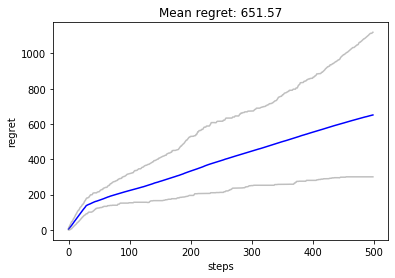

In [24]:
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05, axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95, axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

## UCB

In [25]:
class UCB:
    def __init__(self, nb_arms, c=2., seed=None):
        self._nb_arms = nb_arms
        self._c = c
        self._rng = np.random.RandomState(seed)
        self._q = np.zeros(nb_arms)
        self._n = np.zeros(nb_arms)
        self._t = 0
        
    def act(self, context):
        ###############
        context_id = np.full(self._nb_arms, -1, dtype=int)
        for i,_context in enumerate(context):
            # _context[1] contains the hotel id
            # _context[2] contains the variables
            context_id[_context[1]] = i
        ###############

        if 0 in self._n:
            action = self._rng.choice(np.where(self._n==0)[0])
            action = context_id[action]
        else:
            pred_reward = self._q + np.sqrt(self._c * np.log(self._t) / self._n)
            pred_reward[np.argwhere(context_id == -1)] = -10

            action = random_argmax(self._rng, pred_reward)
            action = context_id[action]
            
        return action
        
    def update(self, context, action, reward):
        # retrieves the original position
        item = context[action][1]

        self._t += 1
        self._n[item] += 1
        self._q[item] += (reward - self._q[item])/self._n[item]
        return

In [26]:
ucb_agent = UCB(env.nb_hotels)
run_exp(ucb_agent, env, nb_steps=100, env_seed=2020)

{'reward': 669.0,
 'regret': 171.0,
 'rewards': array([3., 9., 0., 0., 5., 0., 6., 0., 2., 0., 9., 9., 9., 0., 6., 9., 9.,
        9., 9., 9., 9., 9., 0., 9., 9., 9., 9., 9., 9., 9., 0., 0., 9., 9.,
        9., 9., 0., 6., 9., 9., 9., 9., 9., 9., 0., 9., 9., 9., 0., 9., 9.,
        9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
        9., 9., 9., 9., 0., 9., 9., 9., 9., 9., 9., 9., 9., 9., 5., 6., 0.,
        5., 5., 5., 5., 5., 0., 5., 5., 3., 5., 5., 5., 5., 0., 5.]),
 'users': array([26.,  9., 21., 11.,  2., 11., 21., 29., 19., 23.,  3.,  6., 29.,
        11., 15.,  8., 15., 18.,  9., 25., 25., 15., 11., 10., 10.,  3.,
         5., 28., 12., 23., 24., 16., 12., 17.,  9., 22., 16., 27., 13.,
         6., 20., 13., 29.,  8., 24., 13., 27., 22., 16., 26., 18.,  3.,
        20., 20.,  4.,  5.,  9., 20., 25., 22., 20.,  1., 22.,  2., 25.,
        22., 26.,  8., 19., 28.,  8., 23., 11.,  1.,  2., 29.,  8., 23.,
         7., 27., 23.,  1., 14., 24., 19., 23.,  4., 20.

In [27]:
#nb_exp = 100
#nb_steps = 100
regret = np.zeros(nb_exp)
regrets = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    ucb_agent = UCB(env.nb_hotels)
    res = run_exp(ucb_agent, env, nb_steps, env_seed=i)
    regret[i] = res['regret'] 
    regrets[i] = res['cum_regrets']

results["UCB"] = regrets.mean(axis=0)

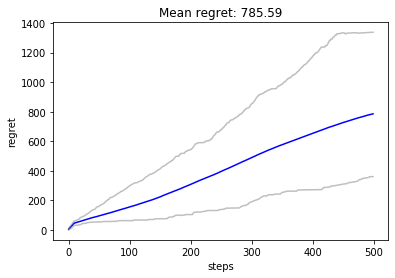

In [28]:
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05, axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95, axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

### Embedding Agent (Offline Recommender System with historical data)

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Dot, Concatenate
import tensorflow as tf

class RegressionModel(Model):
    def __init__(self, embedding_size, nb_users, nb_hotels):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=nb_users,
                                        input_length=1,
                                        name='user_embedding')
        self.hotel_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=nb_hotels,
                                        input_length=1,
                                        name='hotel_embedding')
        self.flatten = Flatten()
        self.dot = Dot(axes=1)
        
    def call(self, inputs):
        user_inputs = inputs[0]
        hotel_inputs = inputs[1]
        
        user_vecs = self.flatten(self.user_embedding(user_inputs))
        hotel_vecs = self.flatten(self.hotel_embedding(hotel_inputs))
        
        y = self.dot([user_vecs, hotel_vecs])

        # Multiplying it by 10 making it closer to our rewards helps to speed up training
        a = tf.constant([10.])
        y = tf.multiply(a,y)

        return y

In [32]:
class EmbeddingAgent:
    def __init__(self, X, Y, nb_users, nb_hotels):
        self._model = RegressionModel(64, nb_users, nb_hotels)
        self._model.compile(optimizer="adam", loss='mae')
        self._model.fit(X, Y,batch_size=64, epochs=120, validation_split=0.1,shuffle=True, verbose=0)
        self._user_embeddings = self._model.get_weights()[0]
        self._hotels_embeddings = self._model.get_weights()[1]
    
    def act(self, context):
        user = context[0][0]
        available_hotels = (np.asarray(context)[:,1]).astype(int)
        user_embedding = self._user_embeddings[user]
        dot_products = np.dot(self._hotels_embeddings[available_hotels,:], user_embedding)
        best_hotels = np.argsort(dot_products)[::-1] #[::-1] reverses order so now the element with the highest expected reward is at first position
        hotel_selected = best_hotels[0]
        return hotel_selected

    def update(self, context, action, reward):
      pass


In [33]:
## General way to train the Embedding Agent by first creating Historical data and then training with it
steps = 250

rand_agent = Random(env.nb_hotels)

#to create historical data
res = run_exp(rand_agent, env, nb_steps=steps, env_seed=2020)
users_values = res['users']
hotels_values = res['items']
rewards_values = res['rewards']
############

Y = rewards_values
X = [users_values, hotels_values]

embagent = EmbeddingAgent(X, Y, env.nb_users, env.nb_hotels)

In [34]:
#nb_exp_emb = 10
#nb_steps = 100
regret = np.zeros(nb_exp_emb)
regrets = np.zeros((nb_exp_emb, nb_steps))
for i in range(nb_exp_emb):
   
    # Generate historical data and train model
    steps = 30
    rand_agent = Random(None)
    res = run_exp(rand_agent, env, nb_steps=steps, env_seed=i)
    users_values = res['users']
    hotels_values = res['actions']
    rewards_values = res['rewards']
    

    Y = rewards_values
    X = [users_values, hotels_values]

    embagent = EmbeddingAgent(X, Y, env.nb_users, env.nb_hotels)
    ############

    # Run experiment
    res = run_exp(embagent, env, nb_steps, env_seed=i)
    regret[i] = res['regret'] 
    regrets[i] = res['cum_regrets']

results["Embedding Agent Offline"] = regrets.mean(axis=0)

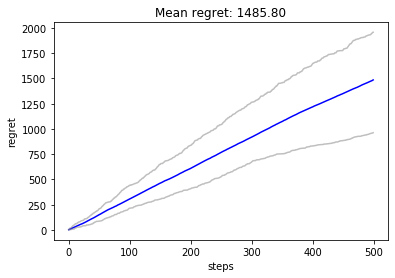

In [35]:
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

### Embedding Agent (Offline / Online: Retrain when 30% new information available)

In [36]:
class EmbeddingAgentOfflineOnline:
    def __init__(self, X, Y, nb_users, nb_hotels):
        self.X = X
        self.Y = Y
        self.nb_users = nb_users
        self.nb_hotels = nb_hotels

        self.runs = 0
        self.last_training = 0

        self.trainModel()


    def trainModel(self):
        self._model = RegressionModel(64, self.nb_users, self.nb_hotels)
        self._model.compile(optimizer="adam", loss='mae')
        self._model.fit(self.X, self.Y,batch_size=64, epochs=150, validation_split=0.1,shuffle=True, verbose=0)
        self._user_embeddings = self._model.get_weights()[0]
        self._hotels_embeddings = self._model.get_weights()[1]

        self.last_training = self.runs
    
    def act(self, context):
        user = context[0][0]
        available_hotels = (np.asarray(context)[:,1]).astype(int)
        user_embedding = self._user_embeddings[user]
        dot_products = np.dot(self._hotels_embeddings[available_hotels,:], user_embedding)
        best_hotels = np.argsort(dot_products)[::-1] #[::-1] reverses order so now the element with the highest expected reward is at first position
        hotel_selected = best_hotels[0]
        return hotel_selected

    def update(self, context, action, reward):
        self.X[0] = np.append(self.X[0], context[action][0])
        self.X[1] = np.append(self.X[1], context[action][1])
        self.Y = np.append(self.Y, reward)

        self.runs += 1
        if self.last_training / self.runs < .7:
          self.trainModel()


In [37]:
#nb_exp_emb = 1
#nb_steps = 100
regret = np.zeros(nb_exp_emb)
regrets = np.zeros((nb_exp_emb, nb_steps))
for i in range(nb_exp_emb):
    # Generate historical data and train model
    steps = 30
    rand_agent = Random(None)
    res = run_exp(rand_agent, env, nb_steps=steps, env_seed=i)
    users_values = res['users']
    hotels_values = res['actions']
    rewards_values = res['rewards']
    

    Y = rewards_values
    X = [users_values, hotels_values]

    embagent = EmbeddingAgentOfflineOnline(X, Y, env.nb_users, env.nb_hotels)

    # Run experiment
    res = run_exp(embagent, env, nb_steps, env_seed=i)
    regret[i] = res['regret'] 
    regrets[i] = res['cum_regrets']
    
    print("Run "+str(i)+" completed")

results["Embedding Agent Offline / Online"] = regrets.mean(axis=0)

Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed
Run 10 completed
Run 11 completed
Run 12 completed
Run 13 completed
Run 14 completed
Run 15 completed
Run 16 completed
Run 17 completed
Run 18 completed
Run 19 completed


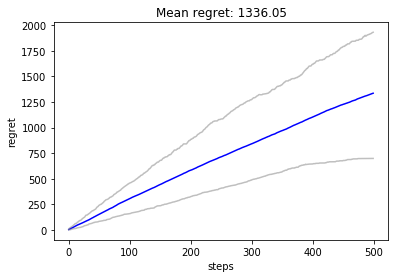

In [38]:
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

### Embedding Model (Online / Epsilon)
This model is a combination of the two pervious approaches. The weighting between exploration and exploitation is done using a decreasing temperature (similiar to simulated annealing). Thus the probability of random exploration decreases over time. 

In [39]:
class EmbeddingAgentEpsilon:
    def __init__(self, nb_users, nb_hotels, d = 0.95, seed_period = 20, seed=None):
        self.X = [np.array([]), np.array([])]
        self.Y = np.array([])
        self.nb_users = nb_users
        self.nb_hotels = nb_hotels

        self.runs = 0
        self.last_training = 0
        self.seed_period = seed_period
        self.d = d
        self.T = 1
        self._rng = np.random.RandomState(seed)


    def trainModel(self):
        self._model = RegressionModel(64, self.nb_users, self.nb_hotels)
        self._model.compile(optimizer="adam", loss='mae')
        self._model.fit(self.X, self.Y,batch_size=64, epochs=150, validation_split=0.1,shuffle=True, verbose=0)
        self._user_embeddings = self._model.get_weights()[0]
        self._hotels_embeddings = self._model.get_weights()[1]

        self.last_training = self.runs
    
    def act(self, context):
        if self.runs <= self.seed_period or self._rng.rand() <= self.T:
            return self._rng.randint(len(context))
        else:
            user = context[0][0]
            available_hotels = (np.asarray(context)[:,1]).astype(int)
            user_embedding = self._user_embeddings[user]
            dot_products = np.dot(self._hotels_embeddings[available_hotels,:], user_embedding)
            best_hotels = np.argsort(dot_products)[::-1] #[::-1] reverses order so now the element with the highest expected reward is at first position
            hotel_selected = best_hotels[0]
            return hotel_selected

    def update(self, context, action, reward):
        self.X[0] = np.append(self.X[0], context[action][0])
        self.X[1] = np.append(self.X[1], context[action][1])
        self.Y = np.append(self.Y, reward)
        
        if self.runs > self.seed_period:
            self.T *= self.d

        self.runs += 1
        if self.last_training / self.runs < .8 and self.runs > self.seed_period:
          self.trainModel()


In [40]:
#nb_exp_emb = 1
#nb_steps = 100
regret = np.zeros(nb_exp_emb)
regrets = np.zeros((nb_exp_emb, nb_steps))
for i in range(nb_exp_emb):
    embagent = EmbeddingAgentEpsilon(env.nb_users, env.nb_hotels)
    res = run_exp(embagent, env, nb_steps, env_seed=i)
    regret[i] = res['regret'] 
    regrets[i] = res['cum_regrets']
    print("Run "+str(i)+" completed")

results["Embedding Agent Online"] = regrets.mean(axis=0)

Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed
Run 10 completed
Run 11 completed
Run 12 completed
Run 13 completed
Run 14 completed
Run 15 completed
Run 16 completed
Run 17 completed
Run 18 completed
Run 19 completed


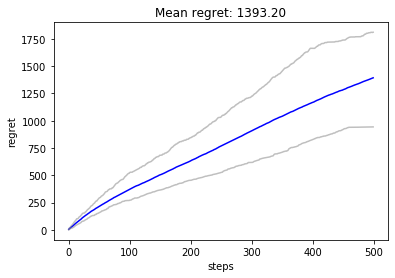

In [41]:
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

### Hybrid Recommender System

In [42]:
class HybridModel(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding')
        
        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.concat = Concatenate()
        
        self.dense1 = Dense(64, activation="relu")
        self.dropout = Dropout(0.3)
        self.dense2 = Dense(64, activation='relu')
        self.dense3 = Dense(1)
        
    def call(self, inputs, training=False):
        user_inputs = inputs[0]
        item_inputs = inputs[1]
        meta_inputs = inputs[2]

        user_vecs = self.flatten(self.user_embedding(user_inputs))
        user_vecs = self.dropout(user_vecs, training=training)

        item_vecs = self.flatten(self.item_embedding(item_inputs))
        item_vecs = self.dropout(item_vecs, training=training)

        input_vecs = self.concat([user_vecs, item_vecs, meta_inputs])

        y = self.dense1(input_vecs)
        y = self.dropout(y, training=training)
        y = self.dense2(y)
        y = self.dropout(y, training=training)
        y = self.dense3(y)
        return y

In [43]:
class HybridEmbeddingAgent:
    def __init__(self, X, Y, nb_users, nb_hotels):
        self.X = X
        self.Y = Y
        self.nb_users = nb_users
        self.nb_hotels = nb_hotels

        self.runs = 0
        self.last_training = 0

        self.trainModel()

    def trainModel(self):
        self._model = HybridModel(64, self.nb_users, self.nb_hotels)
        self._model.compile(optimizer="adam", loss='mae')
        self._model.fit(self.X, self.Y,batch_size=64, epochs=200, validation_split=0.1,shuffle=True,verbose=0)

        self.last_training = self.runs
    
    def act(self, context):
        context = np.asarray(context)
        self.context = context
        _X = [embagent.context[:,0], embagent.context[:,1], np.stack(embagent.context[:,2])]
        predictions = self._model.predict(_X)
        best_hotels = np.argsort(predictions[:,0])[::-1] #[::-1] reverses order so now the element with the highest expected reward is at first position
        hotel_selected = best_hotels[0]
        return hotel_selected

    def update(self, context, action, reward):
        self.X[0] = np.append(self.X[0], context[action][0])
        self.X[1] = np.append(self.X[1], context[action][1])
        self.X[2] = np.append(self.X[2], [context[action][2]], axis = 0)
        
        self.Y = np.append(self.Y, reward)

        self.runs += 1
        if self.last_training / self.runs < .5:
          self.trainModel()


In [ ]:
#nb_exp_emb = 1
#nb_steps = 100
regret = np.zeros(nb_exp_emb)
regrets = np.zeros((nb_exp_emb, nb_steps))
for i in range(nb_exp_emb):
    # Generate historical data and train model
    steps = 30
    rand_agent = Random(None)
    res = run_exp(rand_agent, env, nb_steps=steps, env_seed=i)
    users_values = res['users']
    hotels_values = res['actions']
    variables_values = res['variables']
    rewards_values = res['rewards']
        
    Y = rewards_values
    X = [users_values, hotels_values, np.asarray(variables_values)]
    
    embagent = HybridEmbeddingAgent(X, Y, env.nb_users, env.nb_hotels)

    # Run experiment
    res = run_exp(embagent, env, nb_steps, env_seed=i)
    regret[i] = res['regret'] 
    regrets[i] = res['cum_regrets']
    
    print("Run "+str(i)+" completed")

results["Hybrid Embedding Agent"] = regrets.mean(axis=0)

In [ ]:
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

## Results

In [45]:
import pickle
# Save Results
save_results = True
if save_results:
    with open('results.pkl', 'wb') as f:
        pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

# Load Results
load_results = False
if load_results:
    with open('results.pkl', 'rb') as f:
        results = pickle.load(f)


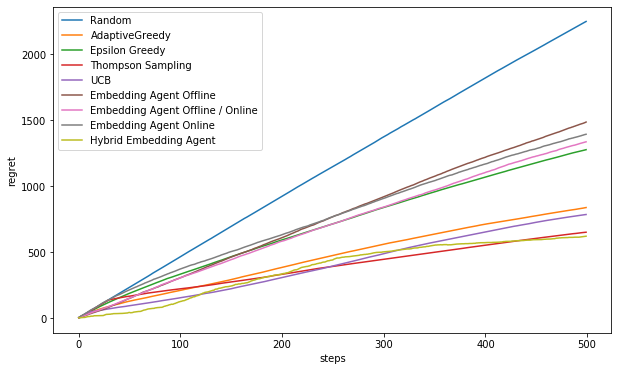

In [8]:
plt.figure(figsize=(10,6))
for key,val in results.items():
    plt.plot(val, label = key)
plt.xlabel('steps')
plt.ylabel('regret')
plt.legend()
plt.savefig("results.png", dpi=500)